# Import packages


In [29]:
import pandas as pd
import json
import re
import time
import unicodedata
import csv
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [32]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [2]:
csv.field_size_limit(sys.maxsize)

131072

# Đọc dữ liệu

In [3]:
cans = pd.read_csv("/content/drive/My Drive/Project 3/candidates.csv", encoding='utf-8')

In [4]:
cans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movie      7698 non-null   object 
 1   qid        7698 non-null   int64  
 2   query      7698 non-null   object 
 3   did        7698 non-null   object 
 4   url        7698 non-null   object 
 5   trueLabel  7698 non-null   object 
 6   ipc        7698 non-null   int64  
 7   icr        7698 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 481.2+ KB


In [6]:
cans['query'] = cans['query'].apply(lambda x: unicodedata.normalize("NFC", x))

In [20]:
# dự đoán theo phương pháp gốc
cans['opredict'] = None
# dự đoán theo phương pháp cải thiện
cans['ipredict'] = None

In [ ]:
cans.head()

In [22]:
# read orcas
orcas = pd.read_csv("/content/drive/MyDrive/Project 3/orcas.csv", encoding='utf-8')

In [23]:
# giữ lại nhũng bản ghi trong orcas mà có qid là qid của các candidates
qid = cans.qid.unique()
small_orcas = orcas[orcas['qid'].isin(qid)]

In [24]:
# xoá orcas, giải phóng bộ nhớ
del orcas

# tổng số connection
small_orcas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15777 entries, 1084 to 18820648
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   qid     15777 non-null  int64 
 1   query   15777 non-null  object
 2   did     15777 non-null  object
 3   url     15777 non-null  object
 4   id      15777 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 739.5+ KB


# Phương pháp gốc

In [91]:
# ngưỡng ipc và icr
ipc_threshold = 0
icr_threshold = 0
for id, row in cans.iterrows():
  if row['ipc'] > ipc_threshold and row['icr'] > icr_threshold:
    cans.loc[id, 'opredict'] = 'y'
  else:
    cans.loc[id, 'opredict'] = 'n'

# Phương pháp cải thiện

Tính độ tương đồng giữa các ứng viên và thực thể bằng cách, tính độ tương đồng giữa nội dung của đường link đầu tiên trong kết quả trả về khi truy vấn bằng thực thể với nội dung những đường link trong tập orcas với câu truy vấn là candidate.

In [25]:
# tải nội dung của từng link 
docs = {}
with open('/content/drive/MyDrive/Project 3/content.tsv', 'r', encoding='utf-8') as tsv_file:
    data = csv.reader(tsv_file, delimiter="\t")
    next(data, None)
    for row in data:
      docs[row[0]] = row[2] + ". " + row[3]

In [26]:
# ktra xem da du content cho tat ca docid hay chua
for did in small_orcas.did.unique().tolist():
  if did not in docs.keys():
    print(doc)

In [27]:
# loai bo di nhung docid khong can thiet
new_docs = {i:docs[i] for i in docs if i in small_orcas.did.unique().tolist()}

In [28]:
# tải nội dung của link đầu tiên trong kết quả truy vấn bằng tên thực thể 
with open("/content/drive/MyDrive/Project 3/contentTopLinkOfMovies.json", encoding='utf-8') as f:
  contentTopLinkOfMovies = json.load(f)
  contentTopLinkOfMovies = {i:contentTopLinkOfMovies[i] for i in contentTopLinkOfMovies \
                            if i in cans.movie.unique().tolist()}

In [30]:
for movie in contentTopLinkOfMovies:
  contentTopLinkOfMovies[movie] = " ".join(contentTopLinkOfMovies[movie])
# contentTopLinkOfMovies['Alice Through the Looking Glass']

In [31]:
# them noi dung cua top link
new_docs.update(contentTopLinkOfMovies)

In [33]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english') # or any other list of your choice
def clean_text(text, ):

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters)))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)

    
    text = text.strip(' ') # strip whitespaces
    text = text.lower() # lowercase
    text = [x for x in text if not x.isnumeric()]     # remove number
    text = "".join(text)
    text = stem_text(text) # stemming
    text = remove_special_characters(text) # remove punctuation and symbols
    text = remove_stopwords(text) # remove stopwords
    #only take words which are greater than 2 characters"
    text = [word for word in text.split() if len(word) > 2]
    text = " ".join(text)
    #text.strip(' ') # strip whitespaces again?

    return "".join(text)

In [34]:
for did in new_docs:
  print(did)
  new_docs[did] = clean_text(new_docs[did])

D2979828
D748803
D1723446
D902415
D2727564
D2209827
D932629
D1927883
D1952617
D3400989
D2464461
D188263
D1639629
D963388
D2198461
D1603377
D2835999
D2445069
D2585764
D342910
D1561782
D32178
D1471136
D2970119
D1127189
D2442483
D3109062
D326980
D441810
D2297846
D588389
D3323699
D1091969
D3496254
D63099
D1790896
D1328653
D214172
D2172050
D835152
D2584633
D3557248
D183580
D1656048
D1833091
D825185
D2882668
D231548
D1281169
D600208
D1895197
D1509078
D1733303
D1313433
D342911
D2697512
D1159526
D143625
D3506377
D2797429
D648008
D948067
D2141478
D1631882
D3470991
D3473426
D152095
D497183
D2826060
D2684068
D1597497
D1820059
D433299
D2795881
D317688
D2859814
D2213119
D1991481
D1855015
D603908
D2703438
D1277719
D1184314
D1691632
D3023477
D2054027
D926678
D1268855
D3129136
D3202251
D1044297
D954479
D31060
D2124226
D2359132
D1295436
D3319980
D1436452
D422322
D1846037
D2283798
D960201
D2766381
D298457
D2194039
D448078
D1928251
D491387
D234059
D1809184
D1784552
D2109554
D3338966
D1723445
D36006
D3304

In [35]:
# danh sách các document
corpus = []
# lưu thứ tự của các document 
order = []
for did in new_docs:
  corpus.append(new_docs[did])
  order.append(did)

In [37]:
# tính tf-idf 
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
X = vectorizer.fit_transform(corpus)
X.shape

(2894, 165053)

In [38]:
# kích thước vector 
n_dimens = 50
# giam kich thuoc cua ma tran bang LSA
svd = TruncatedSVD(n_components=n_dimens, n_iter=10, random_state=42)
Y = svd.fit_transform(X)

In [39]:
# kích thước ma trận vector
Y.shape

(2894, 50)

In [40]:
# vector biểu diễn của từng document 
vector = dict()
for i, did in enumerate(order):
  vector[did] = Y[i]

In [41]:
# tinh toan cosin similarity giua entity va candidate
sim = dict()
for (movie, values) in cans.groupby('movie'):
  sim[movie] = dict()
  # print(movie)
  for qid in values.qid.unique().tolist():
    # print("    ", qid)
    dids = small_orcas[small_orcas['qid'] == qid]['did'].values
    qid_sim = 0
    for did in dids:
      cos_sim = dot(vector[movie], vector[did])/(norm(vector[movie])*norm(vector[did]))
      qid_sim += cos_sim
    qid_sim /= len(dids)
    sim[movie][qid] = qid_sim

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: inva

(array([ 3., 28., 16.,  6., 11.,  0.,  0.,  2.,  1.,  1.]),
 array([0.04633175, 0.05470834, 0.06308493, 0.07146151, 0.0798381 ,
        0.08821468, 0.09659127, 0.10496786, 0.11334444, 0.12172103,
        0.13009761]),
 <a list of 10 Patch objects>)

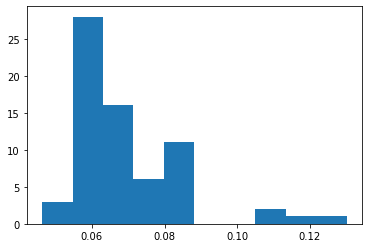

In [42]:
plt.hist(list(sim['Shrek Forever After'].values()))

In [98]:
cans['similarity'] = None

In [99]:
# dự đoán
# ngưỡng
threshold = 0.1
for id, row in cans.iterrows():
  if sim[row['movie']][row['qid']] > threshold:
    cans.loc[id, 'ipredict'] = 'y'
  else:
    cans.loc[id, 'ipredict'] = 'n'
  cans.loc[id, 'similarity'] = sim[row['movie']][row['qid']]

# Loại bỏ common noise khỏi các ứng viên

In [16]:
def remove_common_noise(text):
  text = re.sub("www.|.net|.com|site:", "", text.lower())
  return text

In [48]:
cans['clean_query'] = cans['query'].apply(remove_common_noise)

# Context-sensitive Noise

In [49]:
# dict chứa candidate của phim có dạng movie: [candidates]
candidates = dict()
for (movie, values) in cans.groupby("movie"):
  candidates[movie] = list(set(values['clean_query'].unique()))

In [50]:
movies = list(candidates.keys())
n = len(movies)

In [51]:
n

101

In [ ]:
candidates['Alice Through the Looking Glass']

In [54]:
# xây dựng từ điển context noise 
context_noise = defaultdict(int)
for movie in candidates:
  # print(movie)
  wordsOfCan = []
  for can in candidates[movie]:
    wordsOfCan += can.strip().lower().split(" ")
  wordsOfCan = list(set(wordsOfCan))
  for word in wordsOfCan:
    if len(word) > 1 and word not in movie.lower() and word.isalpha():
      # print("   " + word)
      context_noise[word] += 1

In [55]:
for word in context_noise:
  context_noise[word] = context_noise[word] / len(movies)

In [56]:
context_noise

defaultdict(int,
            {'quotes': 0.06930693069306931,
             'book': 0.18811881188118812,
             'wonderland': 0.009900990099009901,
             'and': 0.1188118811881188,
             'meaning': 0.019801980198019802,
             'lewis': 0.019801980198019802,
             'johnny': 0.04950495049504951,
             'thru': 0.009900990099009901,
             'things': 0.009900990099009901,
             'imdb': 0.6237623762376238,
             'before': 0.009900990099009901,
             'carroll': 0.009900990099009901,
             'mirror': 0.009900990099009901,
             'with': 0.039603960396039604,
             'six': 0.019801980198019802,
             'full': 0.801980198019802,
             'breakfast': 0.009900990099009901,
             'queen': 0.04950495049504951,
             'depp': 0.039603960396039604,
             'cast': 0.9603960396039604,
             'of': 0.5346534653465347,
             'impossible': 0.009900990099009901,
             'red': 0

## Loại bỏ context noise khỏi candidate

In [57]:
def remove_context_noise(text, anpha =  0.01):
  wordsOfCan = text.strip().lower().split(" ")
  result = []
  for word in wordsOfCan:
    if word not in context_noise.keys() or context_noise[word] < anpha:
      result.append(word)
  return " ".join(result)

In [58]:
cans['clean_query'] = cans['clean_query'].apply(lambda x: remove_context_noise(x,anpha=0.05))

In [97]:
cans.sample(5)

,movie,qid,query,did,url,trueLabel,ipc,icr,opredict,ipredict,clean_query
7632,Hansel & Gretel: Witch Hunters,2724571,hansel and gretel witch hunters 2,D3485529,https://en.wikipedia.org/wiki/Hansel_%26_Grete...,n,2,0.107143,y,y,hansel gretel witch hunters 2
7658,Harry Potter and the Goblet of Fire,9539474,harry potter and the goblet of fire imdb,D2131150,http://www.imdb.com/title/tt0330373/,n,1,1.000000,y,y,harry potter goblet fire
5149,X-Men: Days of Future Past,8113611,x-men days of future past 2014 movie,D3266371,https://en.wikipedia.org/wiki/X-Men:_Days_of_F...,y,1,1.000000,y,y,x-men days future past 2014
4972,Wreck-It Ralph,6627056,play fix it felix jr,D2609871,http://lol.disney.com/games/wreck-it-ralph-fix...,n,1,0.757576,y,y,play fix it felix jr
6002,Charlie and the Chocolate Factory,10522850,charlie chocolate,D2198462,https://en.wikipedia.org/wiki/Charlie_and_the_...,y,1,1.000000,y,n,charlie chocolate


# Entity Hypernyms

In [62]:
hypernyms = []
for (query, values) in cans.groupby('query'):
  if len(values['movie'].unique()) > 1:
    # print(query)
    # print(values)
    hypernyms.append(query)

In [ ]:
hypernyms

In [100]:
# Loại bỏ entity hypernym
for id, row in cans.iterrows():
  if row['query'] in hypernyms:
    cans.loc[id, 'ipredict'] = 'n'
    cans.loc[id, 'opredict'] = 'n'

# Đánh giá chất lượng 


In [93]:
opredict = dict()
ipredict = dict()
for (movie, values) in cans.groupby('movie'):
  opredict[movie] = {'tp':[], 'fp':[]}
  ipredict[movie] = {'tp':[], 'fp':[]}
  for id, row in values.iterrows():
    if row['opredict'] == 'y':
      if row['trueLabel'] == 'y':
        opredict[movie]['tp'].append(row['qid'])
      else:
        opredict[movie]['fp'].append(row['qid'])
    if row['ipredict'] == 'y':
      if row['trueLabel'] == 'y':
        ipredict[movie]['tp'].append(row['qid'])
      else:
        ipredict[movie]['fp'].append(row['qid'])

In [95]:
# precision
# phương pháp gốc 
precision_origin = 0 # cu
for movie in opredict:
  tp = len(opredict[movie]['tp'])
  fp = len(opredict[movie]['fp'])
  if tp == 0 or fp == 0:
    precision_origin += 0
  else:
    precision_origin += (tp) / (tp+fp)
print('Precision cua phuong phap goc: ',precision_origin / 101 * 100)

# phương pháp đề xuất
precision_new = 0 # moi 
for movie in ipredict:
  tp = len(ipredict[movie]['tp'])
  fp = len(ipredict[movie]['fp'])
  if tp == 0 or fp == 0:
    precision_new += 0
  else:
    precision_new += (tp) / (tp+fp)
print('Precision cua phuong phap đề xuất: ',precision_new / 101 * 100)

Precision cua phuong phap goc:  44.76975939912632
Precision cua phuong phap đề xuất:  46.60724454070759


In [72]:
frequency = small_orcas.qid.value_counts()

In [96]:
# weighted precision
# phương pháp gốc
w_precsion = 0
for movie in opredict:
  sum_tp = 0
  for qid in opredict[movie]['tp']:
    sum_tp += frequency.loc[qid]
  sum_fp = 0
  for qid in opredict[movie]['fp']:
    sum_fp += frequency.loc[qid]
  try:
    w_precsion += sum_tp / (sum_tp+sum_fp)
  except:
    w_precsion += 0
print("Weighted precision của phương pháp gốc: ", w_precsion / 101*100)

# phương pháp đề xuất
w_precsion = 0
for movie in ipredict:
  sum_tp = 0
  for qid in ipredict[movie]['tp']:
    sum_tp += frequency.loc[qid]
  sum_fp = 0
  for qid in ipredict[movie]['fp']:
    sum_fp += frequency.loc[qid]
  try:
    w_precsion += sum_tp / (sum_tp+sum_fp)
  except:
    w_precsion += 0
print("Weighted precision của phương pháp đề xuất: ", w_precsion / 101*100)


Weighted precision của phương pháp gốc:  40.158124919788044
Weighted precision của phương pháp đề xuất:  42.45897263107591


# Save

In [106]:
result = cans[['movie', 'query', 'clean_query', 'url','ipc', 'icr', 'similarity', \
                   'trueLabel','opredict', 'ipredict']]

In [107]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7698 entries, 0 to 7697
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        7698 non-null   object 
 1   query        7698 non-null   object 
 2   clean_query  7698 non-null   object 
 3   url          7698 non-null   object 
 4   ipc          7698 non-null   int64  
 5   icr          7698 non-null   float64
 6   similarity   7688 non-null   object 
 7   trueLabel    7698 non-null   object 
 8   opredict     7698 non-null   object 
 9   ipredict     7698 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 601.5+ KB


In [108]:
result.head()

,movie,query,clean_query,url,ipc,icr,similarity,trueLabel,opredict,ipredict
0,Harry Potter and the Order of the Phoenix,fifth harry potter movie,fifth harry potter,http://www.imdb.com/title/tt0373889/,1,1.000000,0.285105,y,y,y
1,Harry Potter and the Order of the Phoenix,harry potter,harry potter,http://www.imdb.com/title/tt0373889/,1,0.006797,0.117228,n,n,n
2,Harry Potter and the Order of the Phoenix,harry potter 5,harry potter 5,https://www.goodreads.com/book/show/2.Harry_Po...,4,0.082474,0.154322,y,y,y
3,Harry Potter and the Order of the Phoenix,harry potter and the order of phoenix,harry potter phoenix,https://en.wikipedia.org/wiki/Harry_Potter_and...,6,0.258065,0.149147,y,y,y
4,Harry Potter and the Order of the Phoenix,harry potter and the order of phoenix full movie,harry potter phoenix,"http://www.imdb.com/title/tt0373889/,https://w...",2,0.547170,0.240408,y,y,y


In [110]:
result.to_csv("/content/drive/My Drive/Project 3/result.csv", index=False, encoding='utf-8')